In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
from textwrap import wrap
color_list = [
    "cornflowerblue",
    "orange",
    "deeppink",
    "blueviolet",
    "seagreen",
    "black",
]
linestyle_list=["-","--","-.",":"]
def findall(pattern, string):
    while True:
        match = re.search(pattern, string)
        if not match:
            break
        yield match.group(0)
        string = string[match.end():]

def plot_cdf(
    raw_data,
    file_name,
    linelabels,
    x_label,
    y_label="CDF",
    log_switch=False,
    rotate_xaxis=False,
    ylim_low=0,
    xlim=None,
    xlim_bottom=None,
    fontsize=15,
    legend_font=15,
    loc=2,
    title=None,
    enable_abs=False,
    group_size=1,
):
    _fontsize = fontsize
    fig = plt.figure(figsize=(6, 4))  # 2.5 inch for 1/3 double column width
    ax = fig.add_subplot(111)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.tick_params(axis="y", direction="in")
    ax.tick_params(axis="x", direction="in")
    if log_switch:
        ax.set_xscale("log")

    plt.ylabel(y_label, fontsize=_fontsize)
    plt.xlabel(x_label, fontsize=_fontsize)
    linelabels = ["\n".join(wrap(l, 30)) for l in linelabels]
    for i in range(len(raw_data)):
        data = raw_data[i]
        data = data[~np.isnan(data)]
        if len(data) == 0:
            continue
        if enable_abs:
            data = abs(data)
        # data=random.sample(data,min(1e6,len(data)))
        data_size = len(data)
        # data=list(filter(lambda score: 0<=score < std_val, data))
        # Set bins edges
        data_set = sorted(set(data))
        bins = np.append(data_set, data_set[-1] + 1)

        # Use the histogram function to bin the data
        counts, bin_edges = np.histogram(data, bins=bins, density=False)

        counts = counts.astype(float) / data_size

        # Find the cdf
        cdf = np.cumsum(counts)

        # Plot the cdf
        if i < len(linelabels):
            plt.plot(
                bin_edges[0:-1],
                cdf,
                linestyle=linestyle_list[(i // group_size) % len(linestyle_list)],
                color=color_list[(i % group_size) % len(color_list)],
                label=linelabels[i],
                linewidth=3,
            )
        else:
            plt.plot(
                bin_edges[0:-1],
                cdf,
                linestyle=linestyle_list[(i // group_size) % len(linestyle_list)],
                color=color_list[(i % group_size) % len(color_list)],
                linewidth=3,
            )

    legend_properties = {"size": legend_font}
    plt.legend(
        prop=legend_properties,
        frameon=False,
        loc=loc,
    )

    plt.ylim((ylim_low, 1))
    if xlim_bottom:
        plt.xlim(left=xlim_bottom)
    if xlim:
        plt.xlim(right=xlim)
    # plt.tight_layout()
    # plt.tight_layout(pad=0.5, w_pad=0.04, h_pad=0.01)
    plt.yticks(fontsize=_fontsize)
    plt.xticks(fontsize=_fontsize)
    # plt.grid(True)
    if rotate_xaxis:
        plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment="right")
    if title:
        plt.title(title, fontsize=_fontsize - 5)

In [2]:
lr =10
UNIT_G=1e9
MTU=1000
labels = {
    0: "(0,1KB]",
    1: "(1KB,10KB]",
    2: "(10KB,50KB]",
    3: "(50KB,inf)",
}

DELAY_PROPAGATION_BASE = 1000  # 1us
HEADER_SIZE = 48
BYTE_TO_BIT = 8

In [3]:


def get_base_delay_link(sizes, n_links_passed, lr_bottleneck):
    pkt_head = np.clip(sizes, a_min=0, a_max=MTU)
    delay_propagation = DELAY_PROPAGATION_BASE * n_links_passed
    pkt_size = (pkt_head + HEADER_SIZE) * BYTE_TO_BIT
    delay_transmission = pkt_size / lr_bottleneck

    return delay_propagation + delay_transmission

def get_base_delay_path(
    sizes, n_links_passed, lr_bottleneck
):
    pkt_head = np.clip(sizes, a_min=0, a_max=MTU)
    delay_propagation = DELAY_PROPAGATION_BASE * n_links_passed
    pkt_size = (pkt_head + HEADER_SIZE) * BYTE_TO_BIT
    delay_transmission = (
        pkt_size / lr_bottleneck +
        + pkt_size / (lr_bottleneck) * (n_links_passed - 2)
    )

    return delay_propagation + delay_transmission

[('0/ns3/', (0, 20), '_topology_flows')]
spec=0/ns3/,_topology_flows
sizes=2000, fats=2000, fcts=2000, i_fcts=2000, sldns=2000
1.037s
************************************************************************************************************************************************
0/ns3/
p99 percentile: 5417.119999999999
p99 percentile: 18097.22
p99 percentile: 46985.81999999999
p99 percentile: 1263781.7600000002


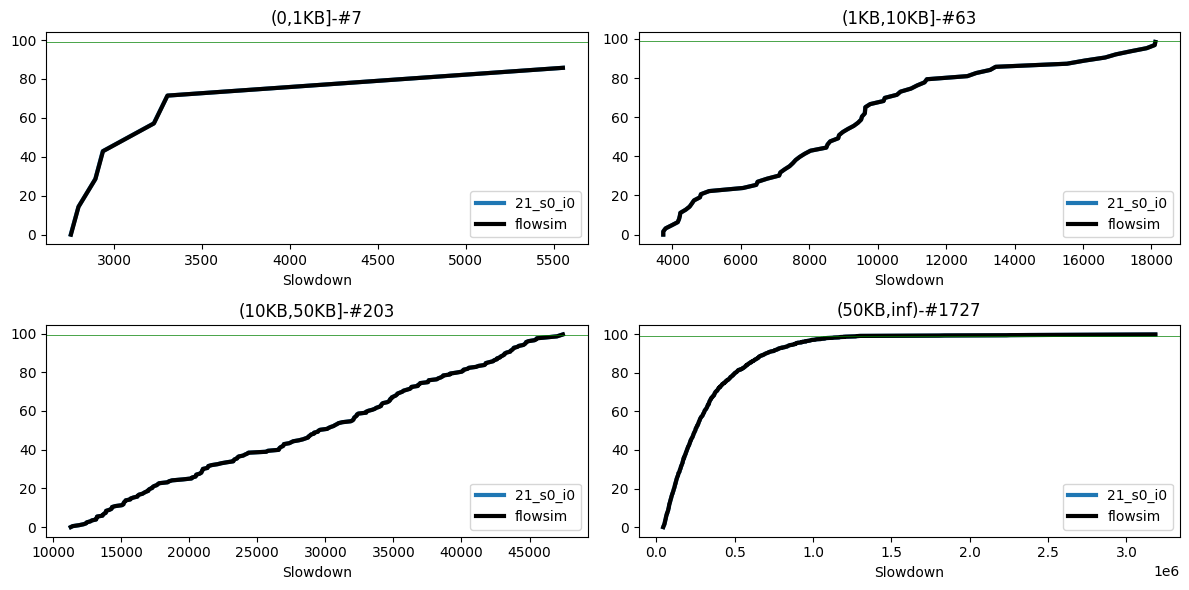

In [13]:

dir_input="/data1/lichenni/projects/per-flow-sim/parsimon-eval/expts/fig_8/eval_train"

topo_type="_topology_flows"

data_list=[]
for shard in np.arange(1):
# for shard in [1,2,3,4]:
    for n_flows in [2000]:
        for n_hosts in [21]:
            for shard_seed in [0]:
                spec=f"{shard}/ns3/"
                dir_input_tmp = f"{dir_input}/{spec}"
                data_list.append((spec,(0,n_hosts-1),topo_type))
               
print(data_list)
# [FINAL]: NS3 vs MaxMinFair
fig_index=0

for spec_idx,(spec,src_dst_pair_target,topo_type) in enumerate(data_list):
    print(f"spec={spec},{topo_type}")
    dir_input_tmp = f"{dir_input}/{spec}"
    
    BDP=10*MTU
    
    fid=np.load(f"{dir_input_tmp}/fid{topo_type}.npy")
    assert np.all(fid[:-1] <= fid[1:])
    sizes = np.load(f"{dir_input_tmp}/fsize.npy")
    fats = np.load(f"{dir_input_tmp}/fat.npy")
    link_list = np.load(f"{dir_input_tmp}/flink.npy")
    link_dict = {link: idx for idx, link in enumerate(link_list)}
    link_info = np.load(
        f"{dir_input_tmp}/flow_to_path.npy",
        allow_pickle=True,
    )
    link_info = [[link_dict[link] for link in link_info[i]] for i in fid]
    
    fcts = np.load(f'{dir_input_tmp}/fct{topo_type}.npy')
    i_fcts = np.load(f'{dir_input_tmp}/fct_i{topo_type}.npy')
    sldns = np.divide(fcts, i_fcts)
    sldns = i_fcts
    print(f"sizes={len(sizes)}, fats={len(fats)}, fcts={len(fcts)}, i_fcts={len(i_fcts)}, sldns={len(sldns)}")
    deq_time_max=np.round(np.max(fats+fcts)/UNIT_G,3)
    print(f"{deq_time_max}s")
    
    # if spec_idx==0:
    n_links_passed = np.array([len(path) for path in link_info])
    lr_bottleneck=lr
    
    base_delay=get_base_delay_path(sizes,n_links_passed,lr_bottleneck)
    i_fcts_flowsim = (sizes + np.ceil(sizes / MTU) * HEADER_SIZE) * BYTE_TO_BIT / lr_bottleneck + base_delay
    fcts_flowsim = np.load(f'{dir_input}/{spec}/flowsim_fct.npy')+ base_delay
    sldns_flowsim = np.divide(fcts_flowsim, i_fcts_flowsim)
    sldns_flowsim = i_fcts_flowsim

    bin = np.digitize(sizes, [MTU, BDP, 5 * BDP])

    print("************************************************************************************************************************************************")
    print(f'{spec}')
    plt.figure(fig_index,figsize=(12, 6))
    for i in range(len(labels)):
        gt = np.extract(bin==i, sldns)
        # if spec_idx==0:
        gt_flowsim = np.extract(bin==i, sldns_flowsim)
        sample_list_flowsim=np.arange(len(gt_flowsim))
            
        print(f"p99 percentile: {np.percentile(gt,99)}")
        # sample_list=sorted(np.random.choice(np.arange(len(gt)),np.min([len(gt),100000]),replace=False))
        sample_list=np.arange(len(gt))
        
        plt.subplot(2, 2, i + 1)
        plt.title(f"{labels[i]}-#{len(gt)}")
        if(len(gt)==0): continue
        # plt.xlim([0, 16])
        plt.plot(np.sort(gt)[sample_list], (np.arange(len(gt))/len(gt)*100)[sample_list], label=dctcp_k_str, linewidth=3)

        # if spec_idx==0:
        plt.plot(np.sort(gt_flowsim)[sample_list_flowsim], (np.arange(len(gt_flowsim))/len(gt_flowsim)*100)[sample_list_flowsim], label="flowsim", linewidth=3,color='black')
            
        plt.axhline(99, color='green', linewidth=0.5)
        # plt.xscale('log')
        plt.xlabel('Slowdown')
        plt.legend()
        # plt.ylim([80, 100])
    plt.tight_layout()
    fig_index+=1